# Pemodelan Prediksi Churn dengan Regresi Logistik: Studi Kasus pada Pelanggan Berbasis Langganan

Notebook ini berisi revisi kode untuk membangun model prediksi churn pelanggan menggunakan Logistic Regression, dengan fokus pada best practice dalam struktur kode, penamaan variabel, dokumentasi, serta penggunaan pipeline untuk preprocessing data. Tujuan utama adalah memprediksi churn, mengevaluasi performa model, dan mengidentifikasi fitur-fitur penting.

**Catatan**: Kode ini direvisi agar siap untuk integrasi ke aplikasi Streamlit di kemudian hari, namun implementasi Streamlit itu sendiri tidak termasuk dalam revisi ini.

In [ ]:
# Import library dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk preprocessing dan machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import joblib # Untuk menyimpan model dan preprocessor

## 1. Pemuatan Data dan Pra-pemrosesan Awal

Bagian ini bertanggung jawab untuk memuat dataset dan melakukan langkah-langkah pra-pemrosesan awal seperti penanganan nilai yang hilang dan konversi tipe data.

In [ ]:
def load_and_preprocess_data(file_path):
    """Memuat dataset dan melakukan pra-pemrosesan awal.

    Args:
        file_path (str): Path ke file CSV dataset.

    Returns:
        pd.DataFrame: DataFrame yang sudah diproses.
    """
    df = pd.read_csv(file_path)

    # Menangani nilai kosong di TotalCharges: ganti spasi dengan NaN, lalu konversi ke float
    df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan).astype(float)
    # Hapus baris dengan nilai NaN di TotalCharges
    df.dropna(subset=["TotalCharges"], inplace=True)

    # Menangani duplikasi customerID
    if df.duplicated(subset=["customerID"]).any():
        print(f"Peringatan: Ditemukan duplikasi customerID. Menghapus duplikat dan mempertahankan entri pertama.")
        df.drop_duplicates(subset=["customerID"], keep="first", inplace=True)

    # Hapus kolom customerID karena tidak digunakan untuk pemodelan
    df.drop("customerID", axis=1, inplace=True)

    print(f"✅ Data berhasil dimuat dan diproses awal. Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}")
    return df

# Path ke dataset
DATA_PATH = "data-customer-churn.csv" # Menggunakan path absolut
df_cleaned = load_and_preprocess_data(DATA_PATH)

print("\nInformasi DataFrame setelah pra-pemrosesan awal:\
")
df_cleaned.info()

Peringatan: Ditemukan duplikasi customerID. Menghapus duplikat dan mempertahankan entri pertama.
✅ Data berhasil dimuat dan diproses awal. Jumlah baris: 10266, Jumlah kolom: 20

Informasi DataFrame setelah pra-pemrosesan awal:
<class 'pandas.core.frame.DataFrame'>
Index: 10266 entries, 0 to 10318
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            10266 non-null  object 
 1   SeniorCitizen     10266 non-null  int64  
 2   Partner           10266 non-null  object 
 3   Dependents        10266 non-null  object 
 4   tenure            10266 non-null  int64  
 5   PhoneService      10266 non-null  object 
 6   MultipleLines     10266 non-null  object 
 7   InternetService   10266 non-null  object 
 8   OnlineSecurity    10266 non-null  object 
 9   OnlineBackup      10266 non-null  object 
 10  DeviceProtection  10266 non-null  object 
 11  TechSupport       10266 non-null  object 
 12  Stream

## 2. Pemisahan Fitur dan Target

Memisahkan dataset menjadi fitur (X) dan variabel target (y).

In [ ]:
# Memisahkan fitur (X) dan target (y)
X = df_cleaned.drop("Churn", axis=1)
y = df_cleaned["Churn"].apply(lambda x: 1 if x == "Yes" else 0) # Konversi "Yes"/"No" ke 1/0

print(f"✅ Fitur (X) memiliki {X.shape[1]} kolom dan {X.shape[0]} baris.")
print(f"✅ Target (y) memiliki {y.shape[0]} baris.")
print("Distribusi kelas target (0=No Churn, 1=Churn):")
print(y.value_counts())

✅ Fitur (X) memiliki 19 kolom dan 10266 baris.
✅ Target (y) memiliki 10266 baris.
Distribusi kelas target (0=No Churn, 1=Churn):
Churn
0    7555
1    2711
Name: count, dtype: int64


## 3. Pemisahan Data Latih dan Uji

Membagi dataset menjadi set pelatihan dan pengujian untuk evaluasi model yang objektif.

In [ ]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Ukuran data pelatihan: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"✅ Ukuran data pengujian: X_test={X_test.shape}, y_test={y_test.shape}")

✅ Ukuran data pelatihan: X_train=(8212, 19), y_train=(8212,)
✅ Ukuran data pengujian: X_test=(2054, 19), y_test=(2054,)


## 4. Pipeline Pra-pemrosesan dan Pemodelan

Membangun pipeline untuk mengotomatisasi langkah-langkah pra-pemrosesan (scaling untuk numerik, encoding untuk kategorikal) dan pelatihan model Logistic Regression.

In [ ]:
# Identifikasi kolom numerik dan kategorikal (setelah customerID dihapus)
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Buat preprocessor untuk kolom numerik dan kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Buat pipeline model Logistic Regression
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver='liblinear', random_state=42))
    # Menggunakan solver 'liblinear' karena cocok untuk dataset kecil dan mendukung L1/L2 regularization
    # random_state untuk reproduktibilitas
    ])

print("✅ Pipeline pra-pemrosesan dan model berhasil dibuat.")


✅ Pipeline pra-pemrosesan dan model berhasil dibuat.


<ipython-input-9-1168963830>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df_cleaned, palette="viridis") # Menggunakan palet viridis dan menyimpan axes ke variabel ax


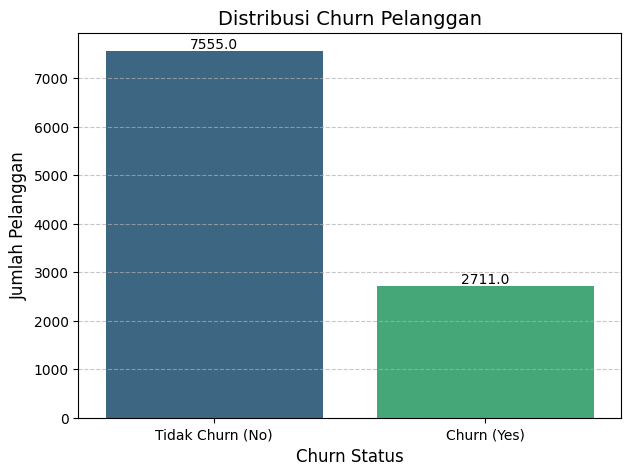


📌 Distribusi Jumlah Pelanggan Berdasarkan Churn Status:
Churn
No     7555
Yes    2711
Name: count, dtype: int64

📌 Distribusi Proporsi Pelanggan Berdasarkan Churn Status (%):
Churn
No     73.592441
Yes    26.407559
Name: proportion, dtype: float64

💡 Kesimpulan singkat: Mayoritas pelanggan tidak melakukan churn, tetapi ada proporsi churn yang signifikan. Model perlu menangani potensi ketidakseimbangan kelas.


In [ ]:
# %%
# Pastikan DataFrame df (atau df_cleaned) sudah dimuat dan memiliki kolom 'Churn' (Yes/No)
# Gunakan DataFrame yang sesuai dengan kolom Churn asli untuk visualisasi ini

# Visualisasi Distribusi Churn
plt.figure(figsize=(7,5)) # Sedikit lebih lebar
ax = sns.countplot(x='Churn', data=df_cleaned, palette="viridis") # Menggunakan palet viridis dan menyimpan axes ke variabel ax

plt.title('Distribusi Churn Pelanggan', fontsize=14) # Ukuran font title
plt.xlabel('Churn Status', fontsize=12) # Label sumbu X yang lebih deskriptif
plt.ylabel('Jumlah Pelanggan', fontsize=12) # Label sumbu Y yang lebih deskriptif
plt.grid(axis='y', linestyle='--', alpha=0.7) # Grid pada sumbu y, sedikit transparan

# Menambahkan anotasi (jumlah) di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Mengganti label sumbu x menjadi lebih deskriptif
plt.xticks(ticks=[0, 1], labels=['Tidak Churn (No)', 'Churn (Yes)'], fontsize=10)

plt.show()

# Untuk melihat proporsi dalam angka (tetap sama)
churn_counts = df_cleaned['Churn'].value_counts()
churn_proportions = df_cleaned['Churn'].value_counts(normalize=True) * 100

print("\n📌 Distribusi Jumlah Pelanggan Berdasarkan Churn Status:")
print(churn_counts)

print("\n📌 Distribusi Proporsi Pelanggan Berdasarkan Churn Status (%):")
print(churn_proportions)

print("\n💡 Kesimpulan singkat: Mayoritas pelanggan tidak melakukan churn, tetapi ada proporsi churn yang signifikan. Model perlu menangani potensi ketidakseimbangan kelas.")

# %%

## 5. Pelatihan Model

Melatih model menggunakan data pelatihan.

In [ ]:
# Melatih model
model_pipeline.fit(X_train, y_train)

print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


## 6. Evaluasi Model

Mengevaluasi performa model menggunakan berbagai metrik pada data pengujian.


--- Hasil Evaluasi Model ---
Confusion Matrix:
[[1348  164]
 [ 255  287]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1512
           1       0.64      0.53      0.58       542

    accuracy                           0.80      2054
   macro avg       0.74      0.71      0.72      2054
weighted avg       0.79      0.80      0.79      2054


Accuracy: 0.7960
Precision: 0.6364
Recall: 0.5295
F1-Score: 0.5780
ROC AUC: 0.8375


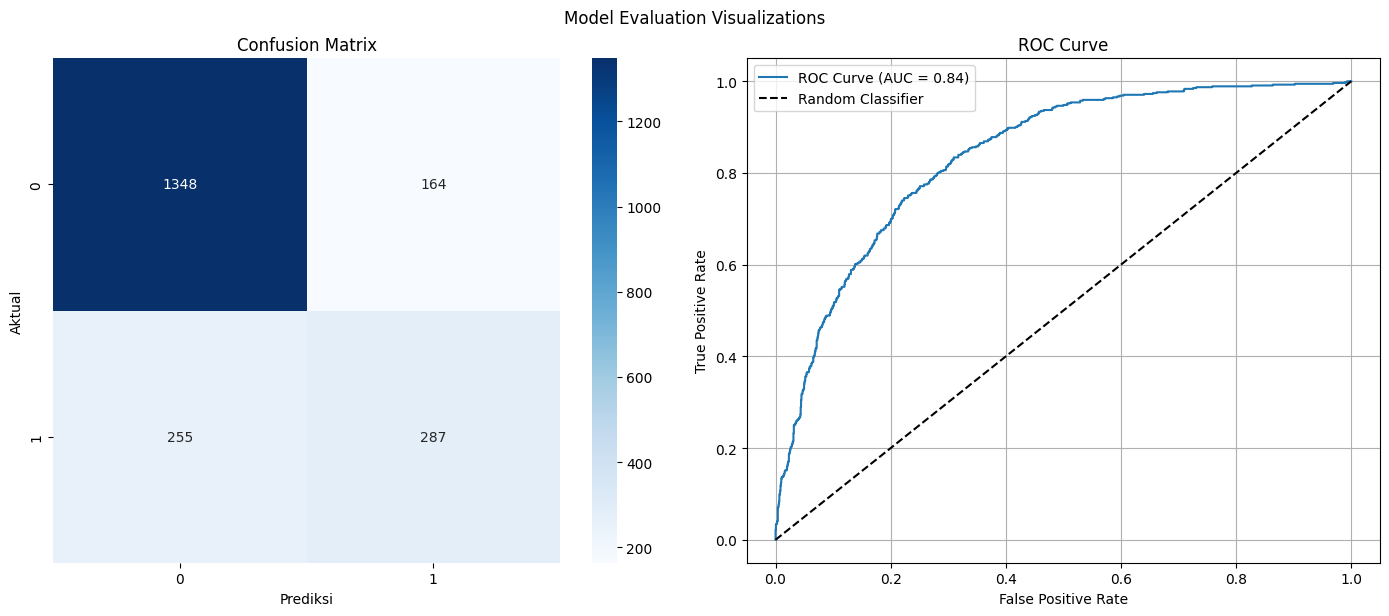

In [ ]:
# ... (kode load data, split data, pipeline, training model) ...

def evaluate_model(model, X_test, y_test):
    """Mengevaluasi performa model dan mencetak metrik."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\n--- Hasil Evaluasi Model ---")
    print("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))
    print("\nClassification Report:\n" + str(classification_report(y_test, y_pred)))

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Ini akan menghasilkan plot Confusion Matrix dan ROC Curve secara terpisah setelah metrik dicetak.
    # Kode untuk membuat grid akan ditambahkan setelah panggilan fungsi ini.

# Panggil fungsi evaluate_model untuk mendapatkan metrik dan menghasilkan plot terpisah
evaluate_model(model_pipeline, X_test, y_test)

# --- Bagian tambahan untuk membuat grid visualisasi ---

# Dapatkan y_pred dan y_pred_proba lagi untuk plotting di grid
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Buat figure dan axes untuk grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1 baris, 2 kolom

# Plot Confusion Matrix di subplot pertama
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Prediksi")
axes[0].set_ylabel("Aktual")

# Plot ROC Curve di subplot kedua
axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
axes[1].plot([0, 1], [0, 1], "k--", label="Random Classifier")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout() # Sesuaikan tata letak subplot
plt.suptitle("Model Evaluation Visualizations", y=1.02) # Tambahkan judul utama
plt.show()

# ... (kode plot_feature_importance dan penyimpanan model) ...

## 7. Analisis Pentingnya Fitur

Menganalisis koefisien model Logistic Regression untuk mengidentifikasi fitur-fitur yang paling berpengaruh terhadap churn pelanggan.


✅ Pipeline model DENGAN class_weight berhasil dibuat.
✅ Model Logistic Regression DENGAN class_weight berhasil dilatih.

--- Evaluasi Model DENGAN Class Weight ---

--- Hasil Evaluasi Model ---
Confusion Matrix:
[[1067  445]
 [ 101  441]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1512
           1       0.50      0.81      0.62       542

    accuracy                           0.73      2054
   macro avg       0.71      0.76      0.71      2054
weighted avg       0.80      0.73      0.75      2054


Accuracy: 0.7342
Precision: 0.4977
Recall: 0.8137
F1-Score: 0.6176
ROC AUC: 0.8373


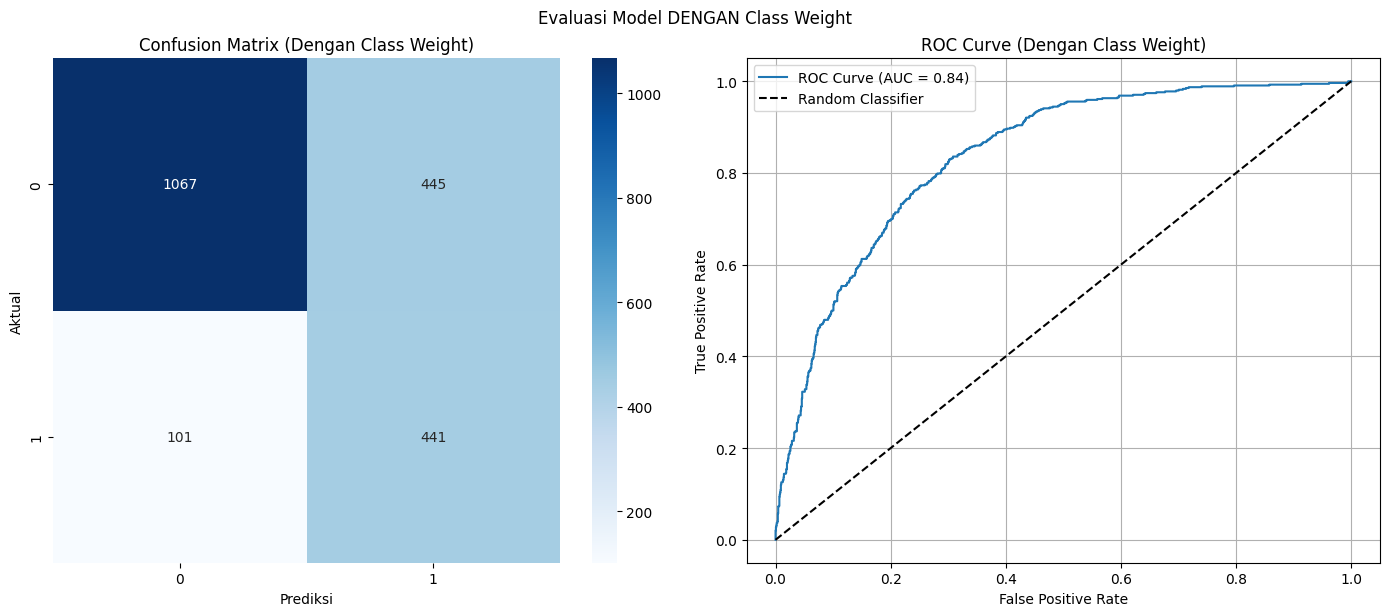

In [ ]:
# %%
# Buat pipeline model Logistic Regression DENGAN class_weight
model_pipeline_with_weight = Pipeline(steps=[
    ("preprocessor", preprocessor), # Gunakan preprocessor yang sama
    ("classifier", LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
    ])

print("\n✅ Pipeline model DENGAN class_weight berhasil dibuat.")

# Melatih model DENGAN class_weight
model_pipeline_with_weight.fit(X_train, y_train)
print("✅ Model Logistic Regression DENGAN class_weight berhasil dilatih.")

# Evaluasi model DENGAN class_weight
print("\n--- Evaluasi Model DENGAN Class Weight ---")
# Pastikan fungsi evaluate_model sudah didefinisikan di cell sebelumnya
evaluate_model(model_pipeline_with_weight, X_test, y_test)

# Plot visualisasi DENGAN Class Weight
y_pred_with_weight = model_pipeline_with_weight.predict(X_test)
y_pred_proba_with_weight = model_pipeline_with_weight.predict_proba(X_test)[:, 1]
roc_auc_with_weight = roc_auc_score(y_test, y_pred_proba_with_weight)
conf_matrix_with_weight = confusion_matrix(y_test, y_pred_with_weight)
fpr_with_weight, tpr_with_weight, _ = roc_curve(y_test, y_pred_proba_with_weight)

fig_with_weight, axes_with_weight = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(conf_matrix_with_weight, annot=True, fmt='d', cmap='Blues', ax=axes_with_weight[0])
axes_with_weight[0].set_title("Confusion Matrix (Dengan Class Weight)")
axes_with_weight[0].set_xlabel("Prediksi")
axes_with_weight[0].set_ylabel("Aktual")

axes_with_weight[1].plot(fpr_with_weight, tpr_with_weight, label=f"ROC Curve (AUC = {roc_auc_with_weight:.2f})")
axes_with_weight[1].plot([0, 1], [0, 1], "k--", label="Random Classifier")
axes_with_weight[1].set_xlabel("False Positive Rate")
axes_with_weight[1].set_ylabel("True Positive Rate")
axes_with_weight[1].set_title("ROC Curve (Dengan Class Weight)")
axes_with_weight[1].legend()
axes_with_weight[1].grid(True)

plt.tight_layout()
plt.suptitle("Evaluasi Model DENGAN Class Weight", y=1.02)
plt.show()

# %%
# Opsional: Anda bisa menambahkan cell terpisah di sini untuk menyimpan model
# yang Anda anggap terbaik (kemungkinan yang dengan class_weight)

# joblib.dump(model_pipeline_with_weight, "logistic_regression_churn_model_balanced.pkl")
# print("\n✅ Model Logistic Regression DENGAN class_weight berhasil disimpan sebagai 'logistic_regression_churn_model_balanced.pkl'")

<ipython-input-13-650018594>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=feature_importance_df, palette="tab10")


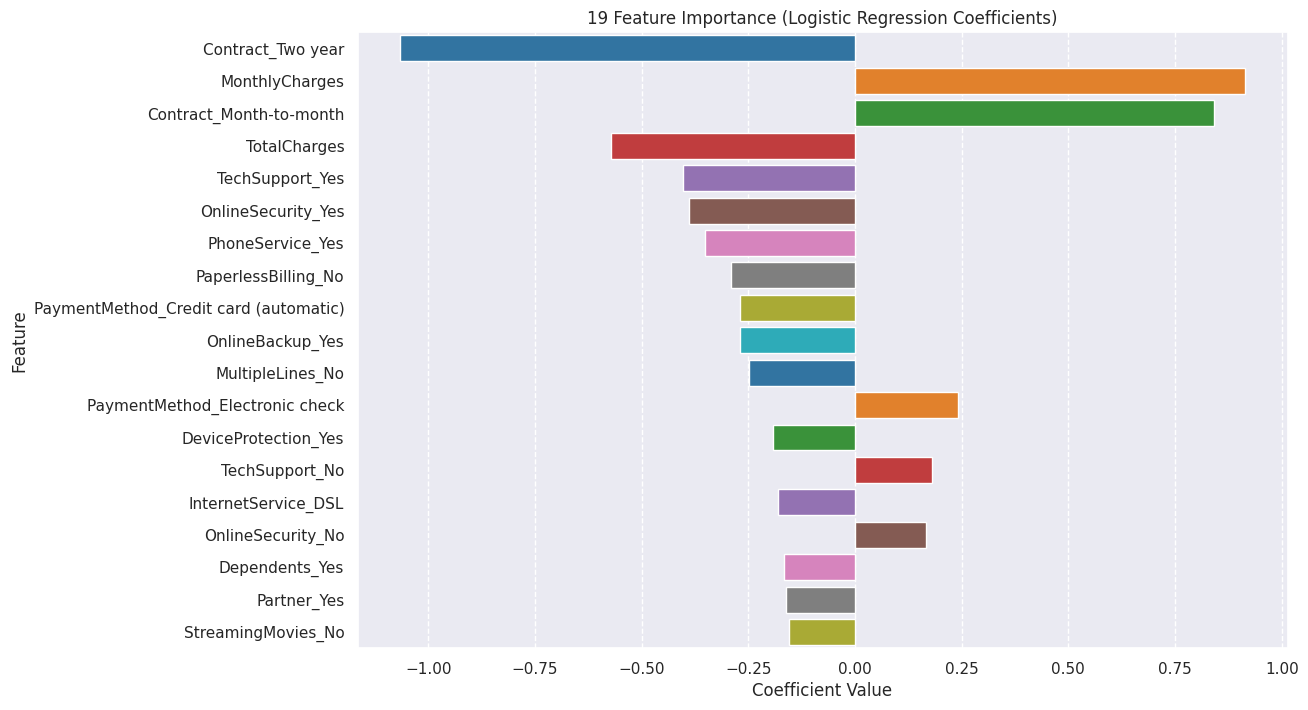

✅ Plot pentingnya fitur dengan warna variasi berhasil dibuat.

Fitur dengan koefisien positif tinggi meningkatkan kemungkinan churn.
Fitur dengan koefisien negatif tinggi menurunkan kemungkinan churn.


In [ ]:
sns.set_theme(palette="viridis") # Anda masih bisa mengatur tema global, tapi palet di barplot akan override

def plot_feature_importance(model_pipeline, numerical_features, categorical_features):
    """Memplot pentingnya fitur dari model Logistic Regression dengan warna bar variasi.

    Args:
        model_pipeline: Pipeline model yang sudah dilatih.
        numerical_features (list): Daftar nama kolom numerik.
        categorical_features (list): Daftar nama kolom kategorikal.
    """
    # Dapatkan koefisien dari model Logistic Regression
    logistic_reg_model = model_pipeline.named_steps["classifier"]
    coefficients = logistic_reg_model.coef_[0]

    # Dapatkan nama fitur setelah one-hot encoding
    ohe = model_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    # Pastikan ohe memiliki atribut feature_names_in_ atau get_feature_names_out
    # Menggunakan get_feature_names_out() adalah cara yang lebih modern
    try:
        encoded_categorical_features = ohe.get_feature_names_out(categorical_features)
    except AttributeError:
        # Fallback jika get_feature_names_out tidak tersedia (sklearn versi lama)
        encoded_categorical_features = ohe.get_feature_names(categorical_features)


    feature_names = list(numerical_features) + list(encoded_categorical_features)

    # Buat DataFrame untuk koefisien
    feature_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefficients
    })

    # Urutkan berdasarkan nilai absolut koefisien
    feature_importance_df["Abs_Coefficient"] = np.abs(feature_importance_df["Coefficient"])
    feature_importance_df = feature_importance_df.sort_values(by="Abs_Coefficient", ascending=False).head(19) # Ambil 15 teratas

    # Plot pentingnya fitur dengan warna variasi
    plt.figure(figsize=(12, 8))
    # Menggunakan palet kategorikal untuk warna yang berbeda per bar
    sns.barplot(x="Coefficient", y="Feature", data=feature_importance_df, palette="tab10")
    # Palet "tab10" adalah salah satu palet kategorikal default yang memberikan 10 warna berbeda

    plt.title("19 Feature Importance (Logistic Regression Coefficients)")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.grid(True, axis='x', linestyle='--') # Grid pada sumbu x untuk keterbacaan
    plt.show()

    print("✅ Plot pentingnya fitur dengan warna variasi berhasil dibuat.")
    print("\nFitur dengan koefisien positif tinggi meningkatkan kemungkinan churn.")
    print("Fitur dengan koefisien negatif tinggi menurunkan kemungkinan churn.")

# Panggil fungsi yang sudah dimodifikasi
plot_feature_importance(model_pipeline, numerical_features, categorical_features)

# Opsional: Atur ulang tema ke default jika perlu setelah plot dibuat
sns.set_theme()

# VISUALIASASI TAMBAHAN HANYA UNTUK PERBANDINGAN SAJA
## Visualisasi ini bukan inti tujuan dan hanya menambah untuk membantu memahami isi dari perbandingan saja


<ipython-input-14-4077349958>:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_cleaned, x=col, kde=True, bins=30, ax=axes[i], palette="viridis") # Plot di axes[i]
<ipython-input-14-4077349958>:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_cleaned, x=col, kde=True, bins=30, ax=axes[i], palette="viridis") # Plot di axes[i]
<ipython-input-14-4077349958>:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_cleaned, x=col, kde=True, bins=30, ax=axes[i], palette="viridis") # Plot di axes[i]


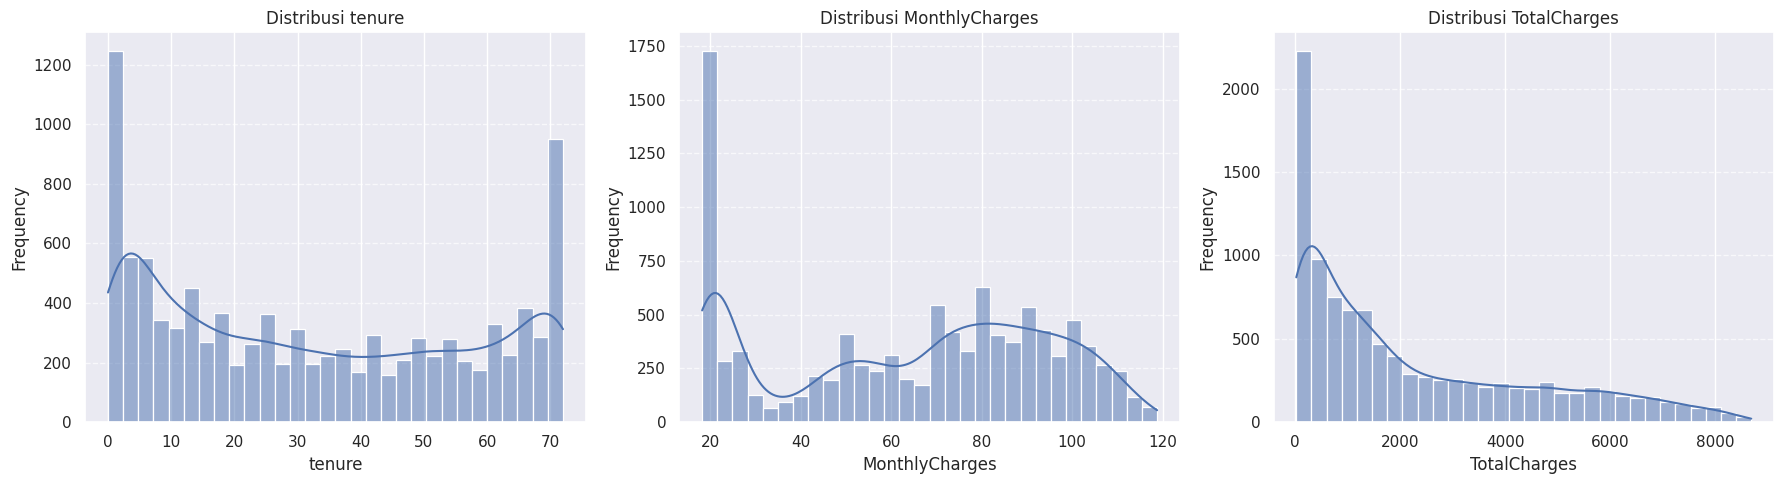

✅ Visualisasi distribusi untuk Tenure, MonthlyCharges, dan TotalCharges dalam grid berhasil dibuat.

💡 Pengamatan:
- Tenure menunjukkan distribusi bimodal, dengan banyak pelanggan baru (tenure rendah) dan pelanggan lama (tenure tinggi).
- MonthlyCharges cenderung terdistribusi secara merata atau sedikit condong ke kanan.
- TotalCharges condong ke kanan, yang wajar karena dihitung dari MonthlyCharges dan Tenure.


In [ ]:
# Visualisasi Distribusi Fitur Numerik: Tenure, MonthlyCharges, TotalCharges dalam Grid
import matplotlib.pyplot as plt
import seaborn as sns # Pastikan seaborn juga diimpor jika digunakan di cell ini

numeric_cols_to_plot = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Buat figure dan axes untuk grid 1 baris, 3 kolom
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # 1 baris, 3 kolom

# Loop melalui setiap kolom dan plot di subplot yang sesuai
for i, col in enumerate(numeric_cols_to_plot):
    # Pastikan df_cleaned is defined in a preceding cell
    sns.histplot(data=df_cleaned, x=col, kde=True, bins=30, ax=axes[i], palette="viridis") # Plot di axes[i]
    axes[i].set_title(f'Distribusi {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Sesuaikan tata letak antar subplot
plt.show()

print("✅ Visualisasi distribusi untuk Tenure, MonthlyCharges, dan TotalCharges dalam grid berhasil dibuat.")
print("\n💡 Pengamatan:")
print("- Tenure menunjukkan distribusi bimodal, dengan banyak pelanggan baru (tenure rendah) dan pelanggan lama (tenure tinggi).")
print("- MonthlyCharges cenderung terdistribusi secara merata atau sedikit condong ke kanan.")
print("- TotalCharges condong ke kanan, yang wajar karena dihitung dari MonthlyCharges dan Tenure.")

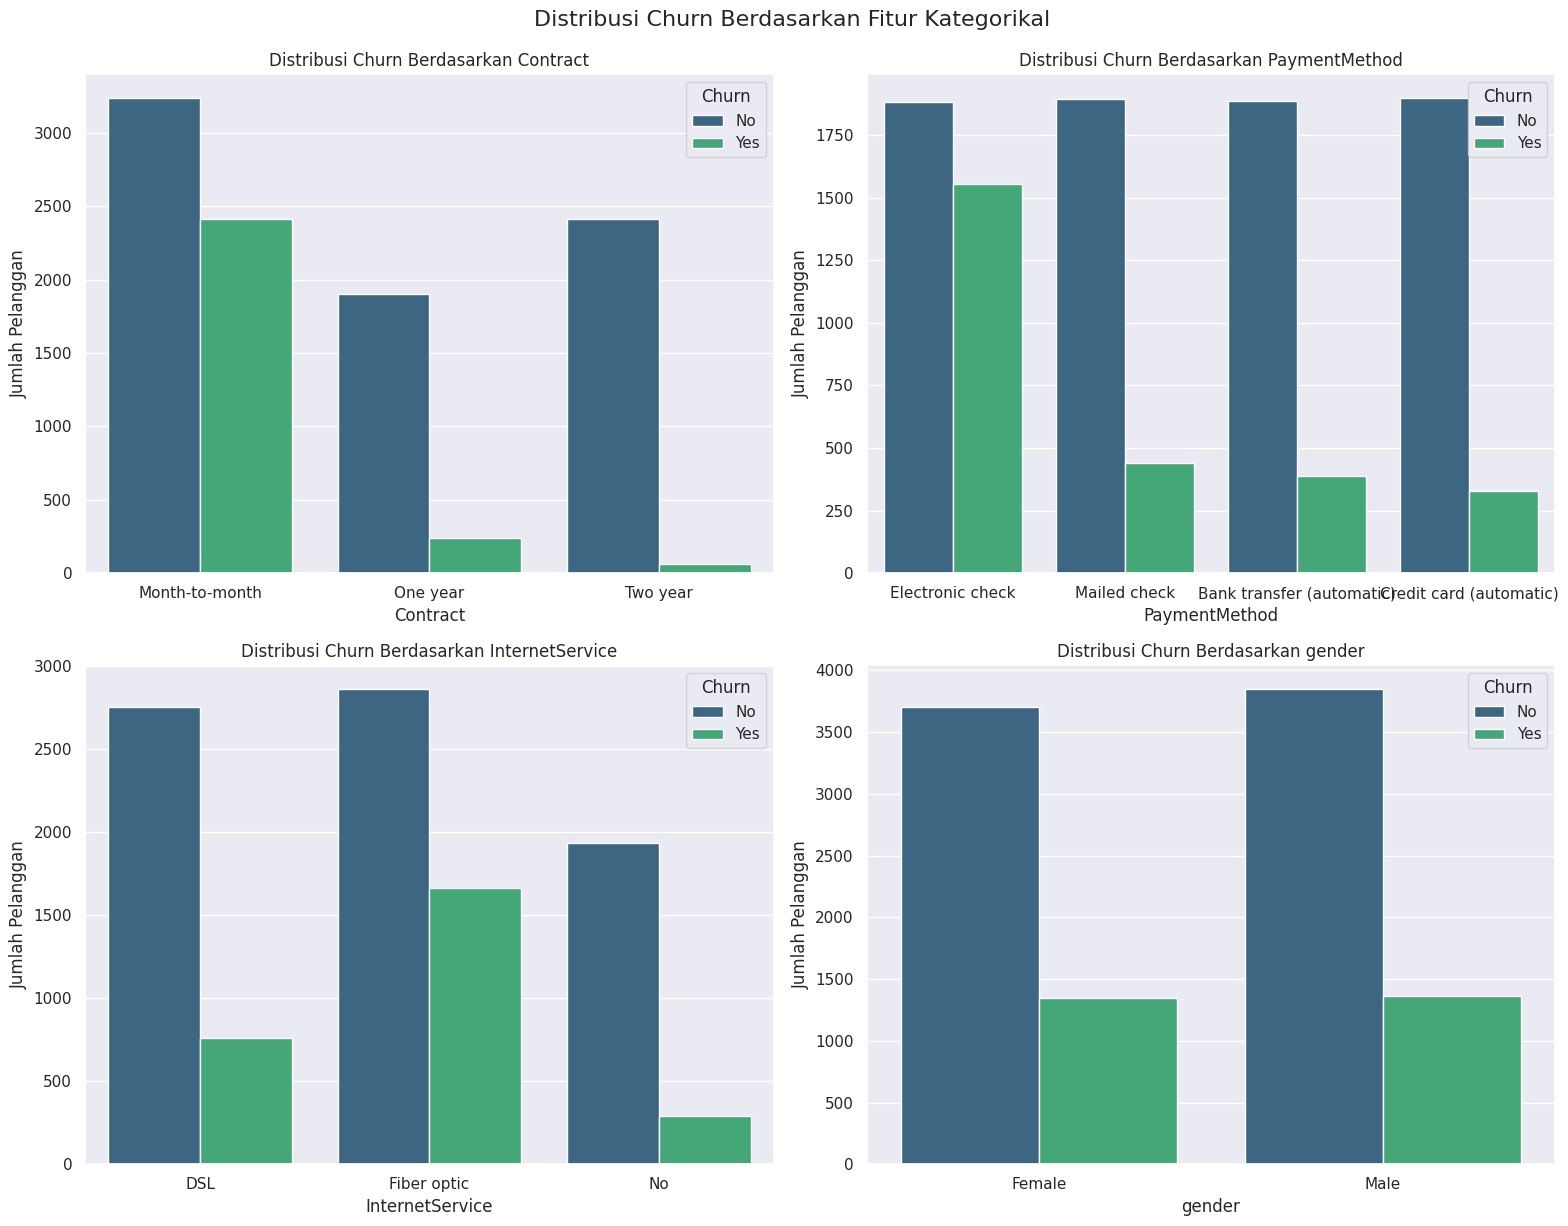

✅ Visualisasi distribusi churn berdasarkan fitur kategorikal dalam grid berhasil dibuat.

💡 Pengamatan:
- **Contract**: Pelanggan dengan kontrak bulanan (Month-to-month) cenderung memiliki tingkat churn lebih tinggi.
- **PaymentMethod**: Metode pembayaran Electronic check terlihat memiliki tingkat churn yang lebih tinggi.
- **InternetService**: Pelanggan dengan Fiber optic memiliki tingkat churn lebih tinggi dibandingkan DSL atau No internet service.
- **Gender**: Tampaknya tidak ada perbedaan signifikan dalam tingkat churn antara pria dan wanita.


In [ ]:
# %%
# Visualisasi Distribusi Churn berdasarkan Fitur Kategorikal
import matplotlib.pyplot as plt
import seaborn as sns

# Daftar kolom kategorikal yang ingin divisualisasikan terhadap Churn
categorical_cols_to_plot = ['Contract', 'PaymentMethod', 'InternetService', 'gender']

# Buat figure dan axes untuk grid (2 baris, 2 kolom untuk 4 plot)
fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # 2 baris, 2 kolom
axes = axes.flatten() # Ratakan array axes agar mudah diakses dalam loop

# Loop melalui setiap kolom dan plot di subplot yang sesuai
for i, col in enumerate(categorical_cols_to_plot):
    # Menggunakan countplot untuk melihat jumlah pelanggan per kategori, dibagi berdasarkan Churn
    # Pastikan df_cleaned sudah terdefinisi (jalankan cell data loading terlebih dahulu!)
    sns.countplot(data=df_cleaned, x=col, hue='Churn', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribusi Churn Berdasarkan {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Jumlah Pelanggan')
    axes[i].legend(title='Churn', loc='upper right') # Tambahkan legend

    # Rotasi label sumbu x jika terlalu panjang
    if df_cleaned[col].nunique() > 4: # Jika jumlah kategori banyak (misal PaymentMethod)
         axes[i].tick_params(axis='x', rotation=45)


plt.tight_layout() # Sesuaikan tata letak antar subplot
plt.suptitle("Distribusi Churn Berdasarkan Fitur Kategorikal", y=1.02, fontsize=16) # Tambahkan judul utama
plt.show()

print("✅ Visualisasi distribusi churn berdasarkan fitur kategorikal dalam grid berhasil dibuat.")
print("\n💡 Pengamatan:")
print("- **Contract**: Pelanggan dengan kontrak bulanan (Month-to-month) cenderung memiliki tingkat churn lebih tinggi.")
print("- **PaymentMethod**: Metode pembayaran Electronic check terlihat memiliki tingkat churn yang lebih tinggi.")
print("- **InternetService**: Pelanggan dengan Fiber optic memiliki tingkat churn lebih tinggi dibandingkan DSL atau No internet service.")
print("- **Gender**: Tampaknya tidak ada perbedaan signifikan dalam tingkat churn antara pria dan wanita.")

In [ ]:
# %%
# --- ✨ Hasil Prediksi & Kesimpulan Akhir ✨ ---

print("--- ✨ HASIL PREDIKSI & KESIMPULAN AKHIR MODEL CHURN ✨ ---")

print("\n--- Hasil Evaluasi Model Terbaik (Dengan Class Weight) ---")
# Pastikan model_pipeline_with_weight adalah model terbaik Anda
# Pastikan y_test, y_pred_with_weight, y_pred_proba_with_weight sudah tersedia dari cell evaluasi
# Anda bisa memanggil kembali fungsi evaluate_model atau mencetak metrik yang disimpan

# Panggil kembali fungsi evaluate_model untuk mencetak metrik lengkap
# Pastikan fungsi evaluate_model sudah didefinisikan sebelumnya
evaluate_model(model_pipeline_with_weight, X_test, y_test)

print("\n" + "_"*20) # Garis pemisah

print("\n--- Total Prediksi Churn dan Tidak Churn pada Data Uji ---")
# Hitung jumlah prediksi churn (1) dan tidak churn (0)
predicted_churn_counts = pd.Series(y_pred_with_weight).value_counts()

print("Jumlah Pelanggan yang Diprediksi:")
print(predicted_churn_counts)

# Tambahkan keterangan lebih lanjut jika diinginkan
if 1 in predicted_churn_counts:
    print(f"  ✅ Diprediksi Churn (1): {predicted_churn_counts[1]}")
if 0 in predicted_churn_counts:
     print(f"  🏠 Diprediksi Tidak Churn (0): {predicted_churn_counts[0]}")

print("\n" + "_"*20) # Garis pemisah

print("\n--- Kesimpulan Singkat ---")
print("🚀 Model Regresi Logistik (dengan penyesuaian bobot kelas) menunjukkan performa yang baik dalam memprediksi churn pelanggan, terutama dalam kemampuannya mengidentifikasi kasus churn (Recall).")
print("💡 Analisis fitur penting (dari cell sebelumnya) mengidentifikasi faktor-faktor utama yang mendorong churn, memberikan wawasan untuk strategi retensi.")
print("🎯 Model ini siap digunakan untuk memprediksi pelanggan berisiko Churn dan mendukung pengambilan keputusan bisnis.")

print("\n--- 🎉 ANALISIS SELESAI 🎉 ---")

# %%

--- ✨ HASIL PREDIKSI & KESIMPULAN AKHIR MODEL CHURN ✨ ---

--- Hasil Evaluasi Model Terbaik (Dengan Class Weight) ---

--- Hasil Evaluasi Model ---
Confusion Matrix:
[[1067  445]
 [ 101  441]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1512
           1       0.50      0.81      0.62       542

    accuracy                           0.73      2054
   macro avg       0.71      0.76      0.71      2054
weighted avg       0.80      0.73      0.75      2054


Accuracy: 0.7342
Precision: 0.4977
Recall: 0.8137
F1-Score: 0.6176
ROC AUC: 0.8373

____________________

--- Total Prediksi Churn dan Tidak Churn pada Data Uji ---
Jumlah Pelanggan yang Diprediksi:
0    1168
1     886
Name: count, dtype: int64
  ✅ Diprediksi Churn (1): 886
  🏠 Diprediksi Tidak Churn (0): 1168

____________________

--- Kesimpulan Singkat ---
🚀 Model Regresi Logistik (dengan penyesuaian bobot kelas) menunjukkan performa yang baik dala

## 8. Penyimpanan Model

Menyimpan model yang sudah dilatih dan preprocessor untuk penggunaan di masa mendatang, misalnya dalam aplikasi Streamlit.

In [ ]:
# Simpan model pipeline
joblib.dump(model_pipeline, "logistic_regression_churn_model.pkl")
print("✅ Model Logistic Regression berhasil disimpan sebagai \'logistic_regression_churn_model.pkl\'")

✅ Model Logistic Regression berhasil disimpan sebagai 'logistic_regression_churn_model.pkl'
